> ## 準備

In [1]:
# フォルダーに移動
% cd /content/drive/My Drive/Colab Notebooks/deeplab/data_analysis_100/

/content/drive/My Drive/Colab Notebooks/deeplab/data_analysis_100


In [2]:
% ls サンプルコード_20200325/5章

5章_顧客の退会を予測する１０本ノック_answer.ipynb  customer_join.csv
5章_顧客の退会を予測する１０本ノック.ipynb         use_log_months.csv


In [3]:
# 日本語フォント用
!pip install japanize-matplotlib

In [4]:
# Load libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [6]:
# Config
PATH = './サンプルコード_20200325/5章/'


> ## ノック41:データを読み込んで利用データを整形しよう

In [7]:
# Chapter 4 で生成したデータを再度インポート
df_customer_join = pd.read_csv(PATH + 'customer_join.csv')
df_use_log_month = pd.read_csv(PATH + 'use_log_months.csv')

In [8]:
df_customer_join.head()

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47


In [9]:
df_customer_join.isnull().sum()

customer_id             0
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
dtype: int64

In [10]:
df_use_log_month.head()

,年月,customer_id,count
0,201804,AS002855,4
1,201804,AS009013,2
2,201804,AS009373,3
3,201804,AS015315,6
4,201804,AS015739,7


In [11]:
df_use_log_month.isnull().sum()

年月             0
customer_id    0
count          0
dtype: int64

In [12]:
# １ヶ月前のデータを使って予測する 
# ４章と同様の方法でデータを作成

year_months = list(df_use_log_month['年月'].unique())
df_use_log = pd.DataFrame()
for i in range(1, len(year_months)):
  tmp = df_use_log_month[df_use_log_month['年月']==year_months[i]]
  tmp.rename(columns={'count':'count_0'}, inplace=True)
  # 基準月の前月も取得
  tmp_before = df_use_log_month[df_use_log_month['年月']==year_months[i-1]]
  del tmp_before['年月']
  tmp_before.rename(columns={'count':'count_1'}, inplace=True)
  # 基準月と前月をまとめる
  tmp = pd.merge(tmp, tmp_before, on='customer_id', how='left')
  df_use_log = pd.concat([df_use_log, tmp], ignore_index=True)
df_use_log.head()

,年月,customer_id,count_0,count_1
0,201805,AS002855,5,4.0
1,201805,AS009373,4,3.0
2,201805,AS015233,7,NaN
3,201805,AS015315,3,6.0
4,201805,AS015739,5,7.0


In [13]:
df_use_log.isnull().sum()

年月                0
customer_id       0
count_0           0
count_1        1201
dtype: int64

> ## ノック42:退会前月の退会顧客データを作成しよう

退会月を予測していては手遅れなので、その前月を予測したい。ということで、退会者の退会前月データを作成する。

In [14]:
# まず各データフレームの日時関連のカラムをまとめて datetime に変換しておく
df_customer_join.dtypes

customer_id           object
name                  object
class                 object
gender                object
start_date            object
end_date              object
campaign_id           object
is_deleted             int64
class_name            object
price                  int64
campaign_name         object
mean                 float64
median               float64
max                    int64
min                    int64
routine_flg            int64
calc_date             object
membership_period      int64
dtype: object

In [15]:
datetime_list = ['start_date', 'end_date', 'calc_date']
for feat in datetime_list:
  df_customer_join[feat] = pd.to_datetime(df_customer_join[feat])

In [16]:
# 退会前月の情報を取得していく
from dateutil.relativedelta import relativedelta
df_exit_customer = df_customer_join[df_customer_join['is_deleted']==True]
df_exit_customer['exit_date'] = df_exit_customer.apply(lambda x:  x['end_date'] - relativedelta(month=1), axis=1)
df_exit_customer['exit_年月'] =  df_exit_customer['exit_date'].dt.strftime('%Y%m')

# 元のデータに退会前月をマージする
df_exit_customer_log = pd.merge(df_use_log, df_exit_customer, on=['customer_id'], how='left')
print('Total rows:  ', len(df_exit_customer_log))
df_exit_customer_log.head()

Total rows:   33851


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,exit_年月
0,201805,AS002855,5,4.0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN
1,201805,AS009373,4,3.0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN
2,201805,AS015233,7,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN
3,201805,AS015315,3,6.0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN
4,201805,AS015739,5,7.0,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN


In [17]:
# 退会者のログ以外は欠損値となっているよう
df_exit_customer_log[df_exit_customer_log['is_deleted']==1].shape

(6429, 23)

In [18]:
# 欠損のある行は削除
# 先ほどの値と一致していることを確認
df_exit_customer_log = df_exit_customer_log.dropna(subset=['name'])
print('Total rows:  ', len(df_exit_customer_log))
df_exit_customer_log.head()

Total rows:   6429


,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,exit_年月
5,201805,AS015746,1,4.0,XXXXX,C01,M,2017-12-01,2018-08-31,CA3,1.0,オールタイム,10500.0,入会費無料,2.600000,3.0,4.0,1.0,0.0,2018-08-31,8.0,2018-01-31,201801
8,201805,AS025956,6,NaN,XXXXXX,C01,M,2018-05-09,2019-02-28,CA2,1.0,オールタイム,10500.0,入会費半額,4.400000,4.5,7.0,1.0,1.0,2019-02-28,9.0,2019-01-28,201901
9,201805,AS029624,8,NaN,XXXXX,C01,M,2018-05-08,2019-01-31,CA2,1.0,オールタイム,10500.0,入会費半額,4.777778,5.0,8.0,1.0,1.0,2019-01-31,8.0,2019-01-31,201901
10,201805,AS030404,1,1.0,XXXX,C01,M,2017-05-01,2018-05-31,CA1,1.0,オールタイム,10500.0,通常,1.000000,1.0,1.0,1.0,0.0,2018-05-31,12.0,2018-01-31,201801
17,201805,AS047907,4,3.0,XXX,C01,M,2016-10-01,2018-08-31,CA1,1.0,オールタイム,10500.0,通常,4.000000,4.0,5.0,3.0,1.0,2018-08-31,22.0,2018-01-31,201801


> ## ノック43:継続顧客のデータを作成しよう

続いて継続者のデータも作成する。

In [19]:
df_conti_customer = df_customer_join.loc[df_customer_join['is_deleted']==0]
df_conti_customer_log = pd.merge(df_use_log, df_conti_customer, on='customer_id', how='left')

# 欠損のある行を削除
df_conti_customer_log.dropna(subset=['name'], inplace=True)
df_conti_customer_log.head()

,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201805,AS002855,5,4.0,XXXX,C03,F,2016-11-01,NaT,CA1,0.0,ナイト,6000.0,通常,4.500000,5.0,7.0,2.0,1.0,2019-04-30,29.0
1,201805,AS009373,4,3.0,XX,C01,F,2015-11-01,NaT,CA1,0.0,オールタイム,10500.0,通常,5.083333,5.0,7.0,3.0,1.0,2019-04-30,41.0
2,201805,AS015233,7,NaN,XXXXX,C01,M,2018-05-13,NaT,CA2,0.0,オールタイム,10500.0,入会費半額,7.545455,7.0,11.0,4.0,1.0,2019-04-30,11.0
3,201805,AS015315,3,6.0,XXXXX,C01,M,2015-07-01,NaT,CA1,0.0,オールタイム,10500.0,通常,4.833333,5.0,7.0,3.0,1.0,2019-04-30,45.0
4,201805,AS015739,5,7.0,XXXXX,C03,M,2017-06-01,NaT,CA1,0.0,ナイト,6000.0,通常,5.583333,5.5,8.0,4.0,1.0,2019-04-30,22.0


In [20]:
print(len(df_conti_customer_log))

27422


In [21]:
# データ数を確認
assert((len(df_conti_customer_log)+len(df_exit_customer_log))==len(df_use_log))
print(len(df_conti_customer_log))
print(len(df_exit_customer_log))
print(len(df_use_log))

27422
6429
33851


In [22]:
# 継続者のデータは、各 customer_id につきランダムな年月を１つ残す
# sample() を使ったシャッフリング方法は初めて知りました
# https://note.nkmk.me/python-pandas-random-sort-shuffle/

df_conti_customer_log = df_conti_customer_log.sample(frac=1).reset_index(drop=True)
df_conti_customer_log.drop_duplicates(subset='customer_id', inplace=True)
df_conti_customer_log.head()

,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,201811,PL753720,4,2.0,XXXX,C01,F,2015-09-01,NaT,CA1,0.0,オールタイム,10500.0,通常,4.333333,4.0,7.0,2.0,1.0,2019-04-30,43.0
1,201807,HI777712,4,7.0,XXXXX,C01,M,2016-12-01,NaT,CA1,0.0,オールタイム,10500.0,通常,5.666667,6.0,9.0,3.0,1.0,2019-04-30,28.0
2,201808,HI878806,5,9.0,XXX,C01,M,2017-11-01,NaT,CA1,0.0,オールタイム,10500.0,通常,6.583333,6.5,9.0,5.0,1.0,2019-04-30,17.0
3,201811,OA252665,8,NaN,XXXXX,C01,F,2018-11-15,NaT,CA1,0.0,オールタイム,10500.0,通常,7.200000,8.0,8.0,5.0,1.0,2019-04-30,5.0
4,201809,GD172600,6,9.0,XX,C02,M,2017-02-01,NaT,CA1,0.0,デイタイム,7500.0,通常,5.416667,5.5,9.0,3.0,1.0,2019-04-30,26.0


In [23]:
# ユニークになっているか確認
df_conti_customer_log['customer_id'].value_counts()

GD629291    1
IK577493    1
TS982817    1
GD763218    1
OA124956    1
           ..
HD482972    1
TS146087    1
HI995135    1
HD320060    1
AS193568    1
Name: customer_id, Length: 2842, dtype: int64

In [24]:
# 直近のデータが多いのは、最近入会して残ってる人の方が多いため
df_conti_customer_log['年月'].value_counts()

201903    402
201901    305
201902    297
201812    287
201811    235
201810    232
201808    227
201807    225
201809    221
201806    208
201805    203
Name: 年月, dtype: int64

In [25]:
# 結合します
df_predict = pd.concat([df_conti_customer_log, df_exit_customer_log], axis=0, ignore_index=True)
df_predict.head()

,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,exit_年月
0,201811,PL753720,4,2.0,XXXX,C01,F,2015-09-01,NaT,CA1,0.0,オールタイム,10500.0,通常,4.333333,4.0,7.0,2.0,1.0,2019-04-30,43.0,NaT,NaN
1,201807,HI777712,4,7.0,XXXXX,C01,M,2016-12-01,NaT,CA1,0.0,オールタイム,10500.0,通常,5.666667,6.0,9.0,3.0,1.0,2019-04-30,28.0,NaT,NaN
2,201808,HI878806,5,9.0,XXX,C01,M,2017-11-01,NaT,CA1,0.0,オールタイム,10500.0,通常,6.583333,6.5,9.0,5.0,1.0,2019-04-30,17.0,NaT,NaN
3,201811,OA252665,8,NaN,XXXXX,C01,F,2018-11-15,NaT,CA1,0.0,オールタイム,10500.0,通常,7.200000,8.0,8.0,5.0,1.0,2019-04-30,5.0,NaT,NaN
4,201809,GD172600,6,9.0,XX,C02,M,2017-02-01,NaT,CA1,0.0,デイタイム,7500.0,通常,5.416667,5.5,9.0,3.0,1.0,2019-04-30,26.0,NaT,NaN


In [26]:
# 全体  継続者数 退会者数
print(len(df_predict))
print(len(df_predict[df_predict['exit_date'].isnull()]))
print(len(df_predict[~df_predict['exit_date'].isnull()]))

9271
2842
6429


> ## ノック44:予測する月の在籍期間を作成しよう

In [27]:
# 在籍期間を特徴量として追加する

def delta_to_month(delta):
  return delta.years*12 + delta.months

df_predict['年月'] = pd.to_datetime(df_predict['年月'], format='%Y%m')
df_predict['user_period'] = 0
df_predict['user_period'] = df_predict.apply(lambda x: delta_to_month(relativedelta(x['年月'], x['start_date'])), axis=1)
df_predict.head()

,年月,customer_id,count_0,count_1,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,exit_年月,user_period
0,2018-11-01,PL753720,4,2.0,XXXX,C01,F,2015-09-01,NaT,CA1,0.0,オールタイム,10500.0,通常,4.333333,4.0,7.0,2.0,1.0,2019-04-30,43.0,NaT,NaN,38
1,2018-07-01,HI777712,4,7.0,XXXXX,C01,M,2016-12-01,NaT,CA1,0.0,オールタイム,10500.0,通常,5.666667,6.0,9.0,3.0,1.0,2019-04-30,28.0,NaT,NaN,19
2,2018-08-01,HI878806,5,9.0,XXX,C01,M,2017-11-01,NaT,CA1,0.0,オールタイム,10500.0,通常,6.583333,6.5,9.0,5.0,1.0,2019-04-30,17.0,NaT,NaN,9
3,2018-11-01,OA252665,8,NaN,XXXXX,C01,F,2018-11-15,NaT,CA1,0.0,オールタイム,10500.0,通常,7.200000,8.0,8.0,5.0,1.0,2019-04-30,5.0,NaT,NaN,0
4,2018-09-01,GD172600,6,9.0,XX,C02,M,2017-02-01,NaT,CA1,0.0,デイタイム,7500.0,通常,5.416667,5.5,9.0,3.0,1.0,2019-04-30,26.0,NaT,NaN,19


> ## ノック45:欠損値を除去しよう

In [28]:
print("データ総数: ", len(df_predict))
df_predict.isna().sum()

データ総数:  9271


年月                      0
customer_id             0
count_0                 0
count_1               715
name                    0
class                   0
gender                  0
start_date              0
end_date             2842
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2842
exit_年月              2842
user_period             0
dtype: int64

In [29]:
# count_1以外のカラムは継続ユーザーによるものなので無視
# counct_1 の欠損だけ考慮して削除する
df_predict.dropna(subset=['count_1'], inplace=True)
print("データ総数: ", len(df_predict))
df_predict.isna().sum()

データ総数:  8556


年月                      0
customer_id             0
count_0                 0
count_1                 0
name                    0
class                   0
gender                  0
start_date              0
end_date             2640
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2640
exit_年月              2640
user_period             0
dtype: int64

In [30]:
# 全体  継続者数  退会者数
print(len(df_predict))
print(len(df_predict[df_predict['exit_date'].isnull()]))
print(len(df_predict[~df_predict['exit_date'].isnull()]))

8556
2640
5916


継続者:退会者 が 1:2 ぐらい

> ## ノック46:文字列型の変数を処理できるように整形しよう

In [31]:
df_predict.columns

Index(['年月', 'customer_id', 'count_0', 'count_1', 'name', 'class', 'gender',
       'start_date', 'end_date', 'campaign_id', 'is_deleted', 'class_name',
       'price', 'campaign_name', 'mean', 'median', 'max', 'min', 'routine_flg',
       'calc_date', 'membership_period', 'exit_date', 'exit_年月',
       'user_period'],
      dtype='object')

In [32]:
# 使用するカテゴリカル変数を dummy変数で置き換えていく
cat_feat_list = ['gender', 'class_name', 'campaign_name']
df_dummies = pd.get_dummies(df_predict[cat_feat_list])
df_dummies.head()

,gender_F,gender_M,class_name_オールタイム,class_name_デイタイム,class_name_ナイト,campaign_name_入会費半額,campaign_name_入会費無料,campaign_name_通常
0,1,0,1,0,0,0,0,1
1,0,1,1,0,0,0,0,1
2,0,1,1,0,0,0,0,1
4,0,1,0,1,0,0,0,1
5,0,1,0,0,1,0,1,0


In [33]:
# 必要なカラムだけ抜き出して、予測に使うデータを作成します
df_predict_final = pd.concat([df_predict[['is_deleted', 'count_1', 'routine_flg', 'user_period']], df_dummies.drop(columns=['gender_M', 'class_name_ナイト', 'campaign_name_通常'])], axis=1)
df_predict_final.head()

,is_deleted,count_1,routine_flg,user_period,gender_F,class_name_オールタイム,class_name_デイタイム,campaign_name_入会費半額,campaign_name_入会費無料
0,0.0,2.0,1.0,38,1,1,0,0,0
1,0.0,7.0,1.0,19,0,1,0,0,0
2,0.0,9.0,1.0,9,0,1,0,0,0
4,0.0,9.0,1.0,19,0,0,1,0,0
5,0.0,5.0,1.0,15,0,0,0,0,1


> ## ノック47:決定木を用いて退会予測モデルを作成してみよう

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# データの分割

X = df_predict_final.drop(columns=['is_deleted'])
y = df_predict_final['is_deleted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [35]:
from sklearn.metrics import accuracy_score
model = DecisionTreeClassifier()
model.fit(X_train , y_train)
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print('Train accuracy Score: ', accuracy_score(y_pred_train, y_train))
print('Test accuracy Score:  ', accuracy_score(y_pred_test, y_test))

Train accuracy Score:  0.9342489772063121
Test accuracy Score:   0.8574766355140186


ちょっと過学習気味

> ## ノック48:予測モデルの評価を行い、モデルのチューニングをしてみよう


In [36]:
# グリッドサーチでパラメターチューニング
from sklearn.model_selection import GridSearchCV

model_dtc = DecisionTreeClassifier(random_state=0)
params = {'criterion': ['gini', 'entropy'],
             'max_depth': [1, 2, 3, 4, 5, 6, 7],
             'min_samples_split': [2, 3]}

model_dtc = GridSearchCV(estimator=model_dtc, 
                     param_grid=params, 
                     cv=4,
                     verbose=1, 
                     scoring='accuracy')

model_dtc.fit(X_train, y_train)
print(model_dtc.best_params_)

Fitting 4 folds for each of 28 candidates, totalling 112 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


{'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 2}


[Parallel(n_jobs=1)]: Done 112 out of 112 | elapsed:    1.1s finished


In [37]:
model = model_dtc.best_estimator_
model.fit(X_train, y_train)

y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
print('Train accuracy Score: ', accuracy_score(y_pred_train, y_train))
print('Test accuracy Score:  ', accuracy_score(y_pred_test, y_test))

Train accuracy Score:  0.8958211572180012
Test accuracy Score:   0.8790887850467289


さっきよりは上がった

> ## ノック49:モデルに寄与している変数を確認しよう


In [42]:
importances = pd.DataFrame({'features': X.columns, 'scores': model.feature_importances_})
importances.sort_values(by='scores', ascending=False, inplace=True)
importances

,features,scores
2,user_period,0.647574
0,count_1,0.223263
1,routine_flg,0.107615
6,campaign_name_入会費半額,0.014093
4,class_name_オールタイム,0.003438
7,campaign_name_入会費無料,0.001796
3,gender_F,0.001241
5,class_name_デイタイム,0.000980


Text(0, 0.5, 'FEATURE NAMES')

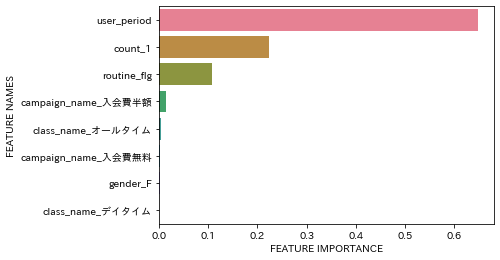

In [53]:
sns.barplot(x=importances['scores'], y=importances['features'], palette='husl')
plt.xlabel('FEATURE IMPORTANCE')
plt.ylabel('FEATURE NAMES')

属性に比べて、利用期間や頻度が強く効いているよう

> ## ノック50:顧客の退会を予測しよう

In [69]:
# 教科書を参考に

def predict_individual(x):
  if x['campaign_name'] == "入会費半額":
    campaign_name_list = [1, 0]
  elif x['campaign_name']  == "入会費無料":
      campaign_name_list = [0, 1]
  elif x['campaign_name'] == "通常":
      campaign_name_list = [0, 0]
  if x['class_name'] == "オールタイム":
      class_name_list = [1, 0]
  elif x['class_name']  == "デイタイム":
      class_name_list = [0, 1]
  elif x['class_name']  == "ナイト":
      class_name_list = [0, 0]
  if x['gender'] == "F":
      gender_list = [1]
  elif x['gender'] == "M":
      gender_list = [0]
  input_data = [x['count_1'], x['routine_flg'], x['user_period']]
  input_data.extend(gender_list)
  input_data.extend(class_name_list)
  input_data.extend(campaign_name_list)
  print(model.predict([input_data]))
  print(model.predict_proba([input_data]))



user = {'campaign_name': '入会費無料',
         'class_name':'オールタイム',
          'gender':'F',
          'count_1':10,
          'routine_flg':1,
          'user_period':10}

user2 = {'campaign_name': '入会費半額',
         'class_name':'デイタイム',
          'gender':'M',
          'count_1':10,
          'routine_flg':0,
          'user_period':10}


predict_individual(user)
predict_individual(user2)

[0.]
[[1. 0.]]
[1.]
[[0. 1.]]


In [71]:
! pip install shap

     |████████████████████████████████| 327kB 2.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456456 sha256=805f4da1b3117b497f764144142f14770fc7f08eb953f92ae2ebc250c5f12b4f
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
Successfully built shap


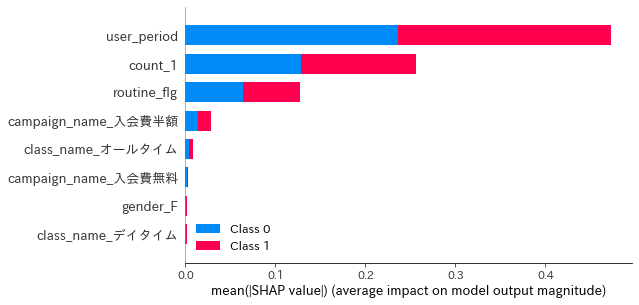

In [74]:
# おまけ
# Shap で可視化してみる

import shap

explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X)
shap.summary_plot(shap_values, X)

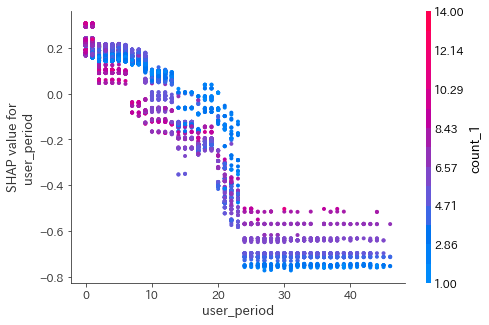

In [85]:
# 利用期間が長いほど離脱しにくい
shap.dependence_plot(ind="user_period", shap_values=shap_values[1], features=X)

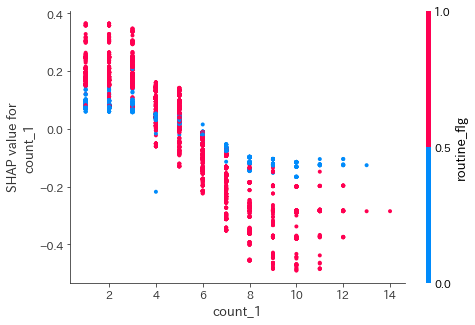

In [84]:
# 利用回数が大きいほど, 離脱しにくい
shap.dependence_plot(ind="count_1", shap_values=shap_values[1], features=X)

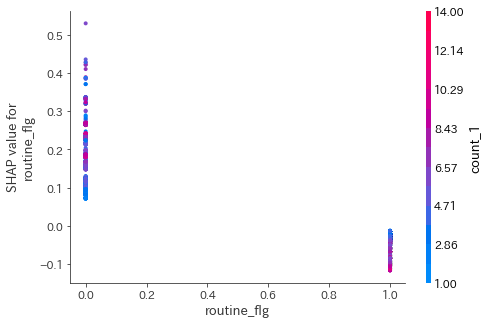

In [83]:
# ルーティーン化してるほど、離脱しにくい
shap.dependence_plot(ind="routine_flg", shap_values=shap_values[1], features=X)